In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Standard Libraries
# File & Regex handling
import os
import re
import json
import nbformat
import time
import re
from collections import Counter, defaultdict
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# NLP tools
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Dimensionality reduction (if needed)
from sklearn.decomposition import PCA

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style='whitegrid')


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define dataset paths (Kaggle auto-mounts datasets under /kaggle/input/)
BASE_PATH = Path('/kaggle/input/meta-kaggle')
CODE_PATH = Path('/kaggle/input/meta-kaggle-code')

print(f"Meta-Kaggle Dataset Path: {BASE_PATH}")
print(f"Meta-Kaggle-Code Dataset Path: {CODE_PATH}")

for dirname, _, filenames in os.walk(BASE_PATH):
    for filename in filenames:
        print(filename)
        
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Meta-Kaggle Dataset Path: /kaggle/input/meta-kaggle
Meta-Kaggle-Code Dataset Path: /kaggle/input/meta-kaggle-code
KernelTags.csv
ModelVariations.csv
KernelVersionCompetitionSources.csv
Datasets.csv
KernelVersionKernelSources.csv
KernelVotes.csv
Submissions.csv
KernelLanguages.csv
Users.csv
ForumMessageVotes.csv
Competitions.csv
DatasetTaskSubmissions.csv
UserAchievements.csv
UserOrganizations.csv
Teams.csv
UserFollowers.csv
CompetitionTags.csv
Kernels.csv
Organizations.csv
Datasources.csv
ModelVersions.csv
ForumTopics.csv
DatasetVersions.csv
ModelVotes.csv
DatasetVotes.csv
TeamMemberships.csv
Forums.csv
KernelVersions.csv
ModelVariationVersions.csv
ForumMessages.csv
KernelVersionDatasetSources.csv
Episodes.csv
EpisodeAgents.csv
KernelAcceleratorTypes.csv
KernelVersionModelSources.csv
ForumMessageReactions.csv
Tags.csv
DatasetTasks.csv
Models.csv
DatasetTags.csv
ModelTags.csv


In [2]:
# Load only the required CSVs
kernels_df = pd.read_csv(BASE_PATH / 'Kernels.csv')
kernel_versions_df = pd.read_csv(BASE_PATH / 'KernelVersions.csv')
users_df = pd.read_csv(BASE_PATH / 'Users.csv')
competitions_df = pd.read_csv(BASE_PATH / 'Competitions.csv')
submissions_df = pd.read_csv(BASE_PATH / 'Submissions.csv')
team_members_df = pd.read_csv(BASE_PATH / 'TeamMemberships.csv')
teams_df = pd.read_csv(BASE_PATH / 'Teams.csv')

In [3]:
# Preview loaded data
print("Kernels Sample:")
display(kernels_df.head())

print("Kernels Version Sample:")
display(kernel_versions_df.head())

print("Users Sample:")
display(users_df.head())

print("Competitions Sample:")
display(competitions_df.head())

print("Submission Sample:")
display(submissions_df.head())

print("Team Members Sample:")
display(team_members_df.head())

print("Teams Sample:")
display(teams_df.head())

Kernels Sample:


,Id,AuthorUserId,CurrentKernelVersionId,ForkParentKernelVersionId,ForumTopicId,FirstKernelVersionId,CreationDate,EvaluationDate,MadePublicDate,IsProjectLanguageTemplate,CurrentUrlSlug,Medal,MedalAwardDate,TotalViews,TotalComments,TotalVotes
0,1,2505,205.0,NaN,NaN,1.0,03/25/2015 18:25:32,03/23/2018,03/25/2015,False,hello,NaN,NaN,432,0,0
1,2,3716,1748.0,NaN,26670.0,2.0,03/25/2015 18:31:07,04/16/2015,03/25/2015,False,rf-proximity,3.0,07/15/2016,9214,1,13
2,4,3716,41.0,NaN,NaN,9.0,03/25/2015 21:57:36,03/23/2018,03/25/2015,False,r-version,NaN,NaN,187,0,0
3,5,28963,19.0,NaN,NaN,13.0,03/25/2015 22:01:04,03/23/2018,03/25/2015,False,test1,NaN,NaN,147,0,0
4,6,3716,21.0,NaN,NaN,15.0,03/25/2015 22:19:00,03/23/2018,03/25/2015,False,are-icons-missing,NaN,NaN,174,0,0


Kernels Version Sample:


,Id,ScriptId,ParentScriptVersionId,ScriptLanguageId,AuthorUserId,CreationDate,VersionNumber,Title,EvaluationDate,IsChange,...,LinesUnchangedFromPrevious,LinesInsertedFromFork,LinesDeletedFromFork,LinesChangedFromFork,LinesUnchangedFromFork,TotalVotes,IsInternetEnabled,RunningTimeInMilliseconds,AcceleratorTypeId,DockerImage
0,1790,314,NaN,2,368,04/17/2015 23:38:09,8.0,Most common first names of passengers,04/17/2015,True,...,10.0,NaN,NaN,NaN,NaN,0,False,4027.0,0,NaN
1,442050,88177,NaN,9,368,11/12/2016 23:51:58,66.0,Trueskill for kitefoil rankings by race,11/12/2016,True,...,812.0,NaN,NaN,NaN,NaN,0,False,682386.0,0,NaN
2,333111,88177,NaN,9,368,08/17/2016 06:53:10,35.0,Trueskill for kitefoil rankings,08/17/2016,True,...,473.0,NaN,NaN,NaN,NaN,0,False,77842.0,0,NaN
3,908,154,NaN,1,28963,04/09/2015 06:38:11,1.0,Button testing,03/23/2018,True,...,NaN,NaN,NaN,NaN,NaN,0,False,244019.0,0,gcr.io/kaggle-private-byod/python@sha256:ad25e...
4,80751,6785,NaN,1,28963,10/05/2015 22:36:46,53.0,Testarooni,10/05/2015,False,...,7.0,NaN,NaN,NaN,NaN,0,False,16083.0,0,NaN


Users Sample:


,Id,UserName,DisplayName,RegisterDate,PerformanceTier,Country,LocationSharingOptOut
0,1,kaggleteam,Kaggle Team,03/24/2011,5,NaN,False
1,368,antgoldbloom,Anthony Goldbloom,01/20/2010,2,United States,False
2,381,iguyon,Isabelle,01/29/2010,2,United States,False
3,383,davidstephan,David Stephan,02/01/2010,0,Australia,False
4,384,gabewarren,Gabe Warren,02/02/2010,0,Australia,False


Competitions Sample:


,Id,Slug,Title,Subtitle,HostSegmentTitle,ForumId,OrganizationId,EnabledDate,DeadlineDate,ProhibitNewEntrantsDeadlineDate,...,Rules,DatasetDescription,TotalCompressedBytes,TotalUncompressedBytes,ValidationSetName,ValidationSetValue,EnableSubmissionModelHashes,EnableSubmissionModelAttachments,HostName,CompetitionTypeId
0,2408,Eurovision2010,Forecast Eurovision Voting,This competition requires contestants to forec...,Featured,2.0,NaN,04/07/2010 07:57:43,05/25/2010 18:00:00,NaN,...,# Competition Rules\n\n\r\n\t<!-- Begin Base R...,# Dataset Description\n\n<p><b>Data provided<b...,800614.0,400307.0,NaN,NaN,False,False,NaN,1
1,2435,hivprogression,Predict HIV Progression,This contest requires competitors to predict t...,Featured,1.0,NaN,04/27/2010 21:29:09,08/02/2010 12:32:00,NaN,...,# Competition Rules\n\n\r\n\t<!-- Begin Base R...,# Dataset Description\n\n<div><div><div>These ...,2141503.0,1095096.0,NaN,NaN,False,False,NaN,1
2,2438,worldcup2010,World Cup 2010 - Take on the Quants,Quants at Goldman Sachs and JP Morgan have mod...,Featured,3094129.0,NaN,06/03/2010 08:08:08,06/11/2010 13:29:00,NaN,...,# Competition Rules\n\n\r\n\t<!-- Begin Base R...,# Dataset Description\n\n<p>We have provided a...,10401.0,10401.0,NaN,NaN,False,False,NaN,1
3,2439,informs2010,INFORMS Data Mining Contest 2010,The goal of this contest is to predict short t...,Featured,4.0,NaN,06/21/2010 21:53:25,10/10/2010 02:28:00,NaN,...,# Competition Rules\n\n\r\n\t<!-- Begin Base R...,"# Dataset Description\n\n<div><span class=""App...",14718207.0,14718207.0,NaN,NaN,False,False,NaN,1
4,2442,worldcupconf,World Cup 2010 - Confidence Challenge,The Confidence Challenge requires competitors ...,Featured,3.0,NaN,06/03/2010 08:08:08,06/11/2010 13:28:00,NaN,...,# Competition Rules\n\n\r\n\t<!-- Begin Base R...,# Dataset Description\n\n<p>We have provided a...,NaN,NaN,NaN,NaN,False,False,NaN,1


Submission Sample:


,Id,SubmittedUserId,TeamId,SourceKernelVersionId,SubmissionDate,ScoreDate,IsAfterDeadline,IsSelected,PublicScoreLeaderboardDisplay,PublicScoreFullPrecision,PrivateScoreLeaderboardDisplay,PrivateScoreFullPrecision
0,2193,652.0,502,NaN,05/04/2010,NaN,False,False,56.25000,56.250000,56.79190,56.791901
1,2195,652.0,502,NaN,05/04/2010,NaN,False,False,53.84619,53.846199,56.64739,56.647400
2,2196,652.0,502,NaN,05/04/2010,NaN,False,False,52.40380,52.403801,55.78030,55.780300
3,2202,728.0,505,NaN,05/06/2010,NaN,False,False,50.00000,50.000000,48.55490,48.554901
4,2204,728.0,505,NaN,05/06/2010,NaN,False,False,48.55770,48.557701,56.93640,56.936401


Team Members Sample:


,Id,TeamId,UserId,RequestDate
0,16458,518,635,NaN
1,16464,526,839,NaN
2,16465,527,816,NaN
3,16466,528,778,NaN
4,16467,529,747,NaN


Teams Sample:


,Id,CompetitionId,TeamLeaderId,TeamName,ScoreFirstSubmittedDate,LastSubmissionDate,PublicLeaderboardSubmissionId,PrivateLeaderboardSubmissionId,IsBenchmark,Medal,MedalAwardDate,PublicLeaderboardRank,PrivateLeaderboardRank,WriteUpForumTopicId
0,496,2435,647.0,team1,NaN,05/04/2010,2192.0,2192.0,False,NaN,09/06/2018,59.0,83.0,NaN
1,497,2435,619.0,jonp,NaN,04/30/2010,2182.0,2182.0,False,3.0,07/15/2016,41.0,25.0,NaN
2,499,2435,663.0,Bwaas,NaN,05/01/2010,2184.0,2184.0,False,NaN,09/06/2018,102.0,100.0,NaN
3,500,2435,673.0,Thylacoleo,NaN,07/10/2010,2187.0,2187.0,False,3.0,07/15/2016,31.0,23.0,NaN
4,501,2435,435.0,pjonesdotcda,NaN,05/05/2010,2194.0,2191.0,False,NaN,09/06/2018,67.0,80.0,NaN


## Correlation Between Participant Activity Patterns and Leaderboard Performance

In [4]:
# Rename SubmittedUserId to UserId for consistency
submissions_clean_df = submissions_df.rename(columns={"SubmittedUserId": "UserId"})

# Now continue as before
submissions_clean_df["Date"] = pd.to_datetime(submissions_clean_df["SubmissionDate"])
user_scores = submissions_clean_df.groupby("UserId")["PublicScoreFullPrecision"].max().reset_index(name="BestScore")
submission_counts = submissions_clean_df.groupby("UserId").size().reset_index(name="SubmissionCount")

# Sort and compute time difference
submissions_clean_df = submissions_clean_df.sort_values(by=["UserId", "Date"])
submissions_clean_df["TimeDiff"] = submissions_clean_df.groupby("UserId")["Date"].diff().dt.total_seconds()
avg_time_diff = submissions_clean_df.groupby("UserId")["TimeDiff"].mean().reset_index(name="AvgSubmissionInterval")

# Merge with users_df
activity_df = users_df[["Id", "PerformanceTier"]].rename(columns={"Id": "UserId"})
activity_df = activity_df.merge(user_scores, on="UserId", how="left")
activity_df = activity_df.merge(submission_counts, on="UserId", how="left")
activity_df = activity_df.merge(avg_time_diff, on="UserId", how="left")

## Relationship Between Notebook (Kernel) Sharing and Final Rankings

Correlation between kernel sharing and best score: nan


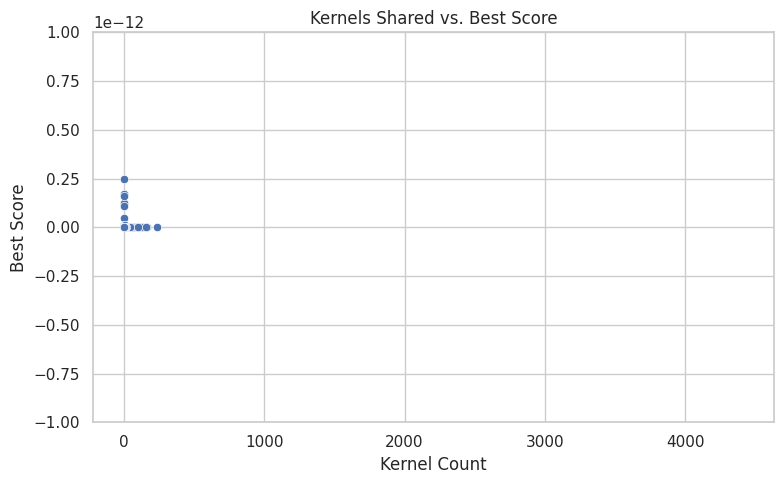

In [5]:
# Kernel count per user
kernel_counts = kernels_df.groupby("AuthorUserId").size().reset_index(name="KernelCount")

# Merge with score
notebook_score_df = user_scores.merge(kernel_counts, left_on="UserId", right_on="AuthorUserId", how="left").fillna(0)

# Correlation
corr_value = notebook_score_df["KernelCount"].corr(notebook_score_df["BestScore"])
print(f"Correlation between kernel sharing and best score: {corr_value:.2f}")

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=notebook_score_df, x="KernelCount", y="BestScore")
plt.title("Kernels Shared vs. Best Score")
plt.xlabel("Kernel Count")
plt.ylabel("Best Score")
plt.tight_layout()
plt.show()


## Team Formation Strategies vs. Solo Performance

In [6]:
print(teams_df.columns.tolist())

team_perf_df = teams_df.dropna(subset=["PrivateLeaderboardRank"])
team_perf_df = team_perf_df[team_perf_df["PrivateLeaderboardRank"] > 0]
team_perf_df = team_perf_df[
    (team_perf_df["PrivateLeaderboardRank"].notna()) &
    (team_perf_df["PrivateLeaderboardRank"] > 0)
]
print(team_perf_df.isna().sum())
print(team_perf_df.head())
print(team_perf_df["Medal"].value_counts())

print(team_perf_df["PrivateLeaderboardRank"].describe())
print(team_perf_df["PrivateLeaderboardRank"].isna().sum())

['Id', 'CompetitionId', 'TeamLeaderId', 'TeamName', 'ScoreFirstSubmittedDate', 'LastSubmissionDate', 'PublicLeaderboardSubmissionId', 'PrivateLeaderboardSubmissionId', 'IsBenchmark', 'Medal', 'MedalAwardDate', 'PublicLeaderboardRank', 'PrivateLeaderboardRank', 'WriteUpForumTopicId']
Id                                     0
CompetitionId                          0
TeamLeaderId                           0
TeamName                             200
ScoreFirstSubmittedDate           853315
LastSubmissionDate                     0
PublicLeaderboardSubmissionId          0
PrivateLeaderboardSubmissionId         0
IsBenchmark                            0
Medal                             790805
MedalAwardDate                    780784
PublicLeaderboardRank                  0
PrivateLeaderboardRank                 0
WriteUpForumTopicId               848293
dtype: int64
    Id  CompetitionId  TeamLeaderId      TeamName  ScoreFirstSubmittedDate  \
0  496           2435         647.0         team1  

In [7]:
print(team_perf_df.describe())

                 Id  CompetitionId  TeamLeaderId  ScoreFirstSubmittedDate  \
count  8.533150e+05  853315.000000  8.533150e+05                      0.0   
mean   5.662016e+06   27605.798440  4.451227e+06                      NaN   
std    4.236836e+06   23589.345063  5.217045e+06                      NaN   
min    4.960000e+02    2408.000000  6.200000e+01                      NaN   
25%    1.665782e+06    8540.000000  6.279220e+05                      NaN   
50%    5.505700e+06   20270.000000  2.471701e+06                      NaN   
75%    9.049324e+06   35887.000000  6.448974e+06                      NaN   
max    1.390661e+07   95426.000000  2.716653e+07                      NaN   

       PublicLeaderboardSubmissionId  PrivateLeaderboardSubmissionId  \
count                   8.533150e+05                    8.533150e+05   
mean                    1.863977e+07                    1.864005e+07   
std                     1.272791e+07                    1.272777e+07   
min               

In [8]:
# Check for infinite values and replace with NaN
# Clean 'PublicScoreFullPrecision' in one go
submissions_clean_df = submissions_clean_df.replace([np.inf, -np.inf], np.nan)

# Drop invalid or extreme values
submissions_clean_df = submissions_clean_df[
    submissions_clean_df['PublicScoreFullPrecision'].between(0.00001, 100, inclusive="both")
]

# Compute best team scores
team_scores_df = submissions_clean_df.groupby("TeamId")["PublicScoreFullPrecision"].max().reset_index(name="BestTeamScore")

# Optional: Debug info
print(submissions_clean_df.isna().sum())
print(submissions_clean_df.head())

Id                                      0
UserId                               1098
TeamId                                  0
SourceKernelVersionId             9427007
SubmissionDate                          0
ScoreDate                          352361
IsAfterDeadline                         0
IsSelected                              0
PublicScoreLeaderboardDisplay           0
PublicScoreFullPrecision                0
PrivateScoreLeaderboardDisplay          0
PrivateScoreFullPrecision               0
Date                                    0
TimeDiff                           513032
dtype: int64
           Id  UserId  TeamId  SourceKernelVersionId SubmissionDate ScoreDate  \
2567    20655    62.0    3768                    NaN     02/25/2011       NaN   
3467    20835    62.0    3768                    NaN     02/28/2011       NaN   
404293   4980   368.0     951                    NaN     08/09/2010       NaN   
425087   5075   368.0     967                    NaN     08/10/2010       N

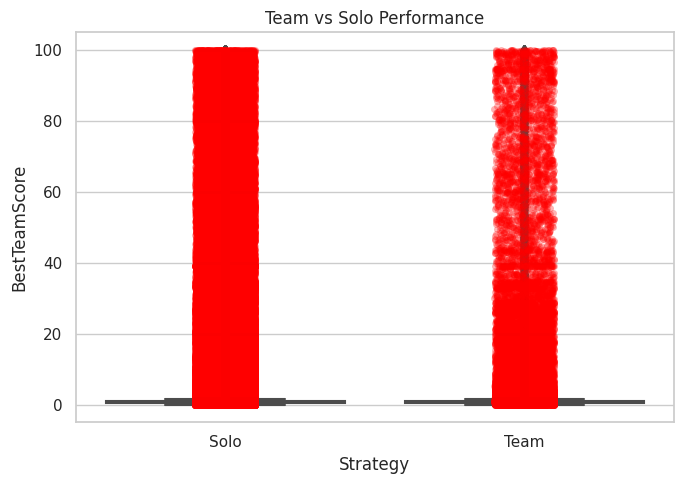

In [9]:
# Team size
# Compute team size
team_size_df = team_members_df.groupby("TeamId")["UserId"].nunique().reset_index(name="TeamSize")

# Compute best team scores
team_scores_df = submissions_clean_df.groupby("TeamId")["PublicScoreFullPrecision"].max().reset_index(name="BestTeamScore")

# Merge size and score
team_perf_df = team_size_df.merge(team_scores_df, on="TeamId", how="inner")

# Clean and filter scores
team_perf_df['BestTeamScore'] = team_perf_df['BestTeamScore'].replace([np.inf, -np.inf], np.nan)
team_perf_df = team_perf_df.dropna(subset=['BestTeamScore'])
team_perf_df = team_perf_df[team_perf_df['BestTeamScore'].between(0.00001, 100)]

# Strategy label
team_perf_df["Strategy"] = team_perf_df["TeamSize"].apply(lambda x: "Solo" if x == 1 else "Team")

# Plot
plt.figure(figsize=(7, 5))
sns.boxplot(data=team_perf_df, x="Strategy", y="BestTeamScore")
sns.stripplot(data=team_perf_df, x="Strategy", y="BestTeamScore", color='red', alpha=0.3, jitter=True)
plt.title("Team vs Solo Performance")
plt.tight_layout()
plt.show()

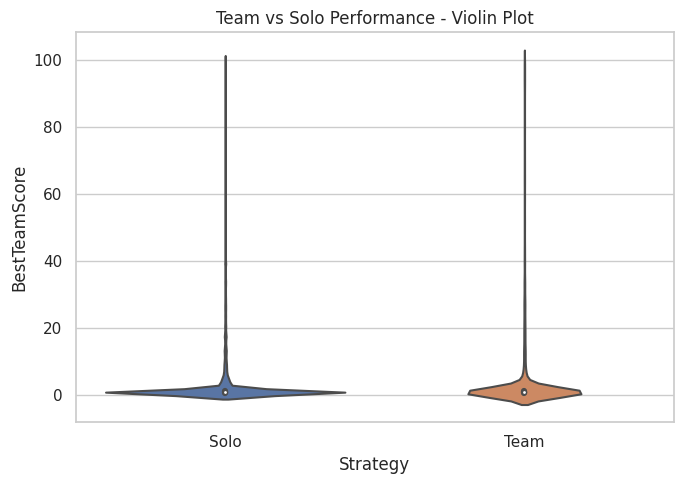

In [10]:
plt.figure(figsize=(7, 5))
sns.violinplot(data=team_perf_df, x="Strategy", y="BestTeamScore")
plt.title("Team vs Solo Performance - Violin Plot")
plt.tight_layout()
plt.show()

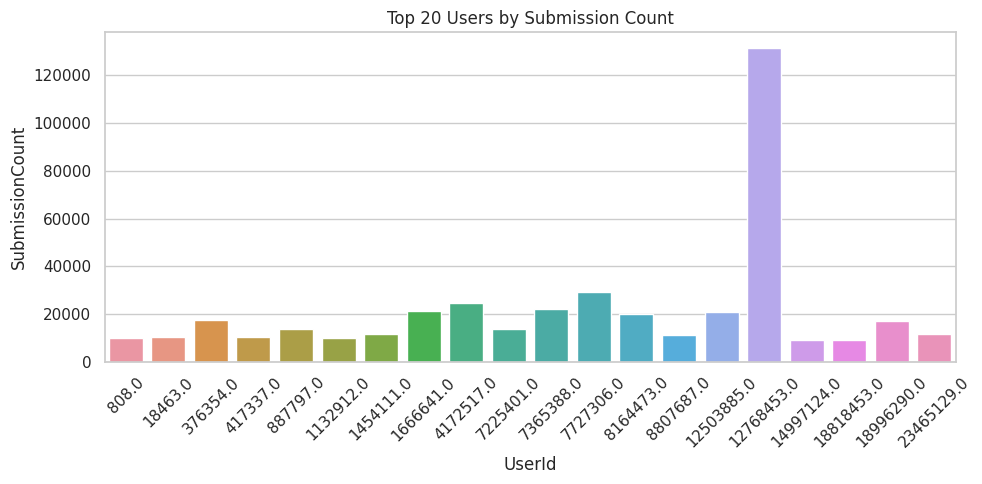

In [11]:
# 1. User-level submission counts and average best score
user_perf_df = submissions_clean_df.groupby('UserId').agg(
    SubmissionCount=('Id', 'count'),
    AvgBestScore=('PublicScoreFullPrecision', 'mean')
).reset_index()

# Plot submission counts per user (top 20)
top_users = user_perf_df.sort_values('SubmissionCount', ascending=False).head(20)
plt.figure(figsize=(10,5))
sns.barplot(data=top_users, x='UserId', y='SubmissionCount')
plt.title("Top 20 Users by Submission Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

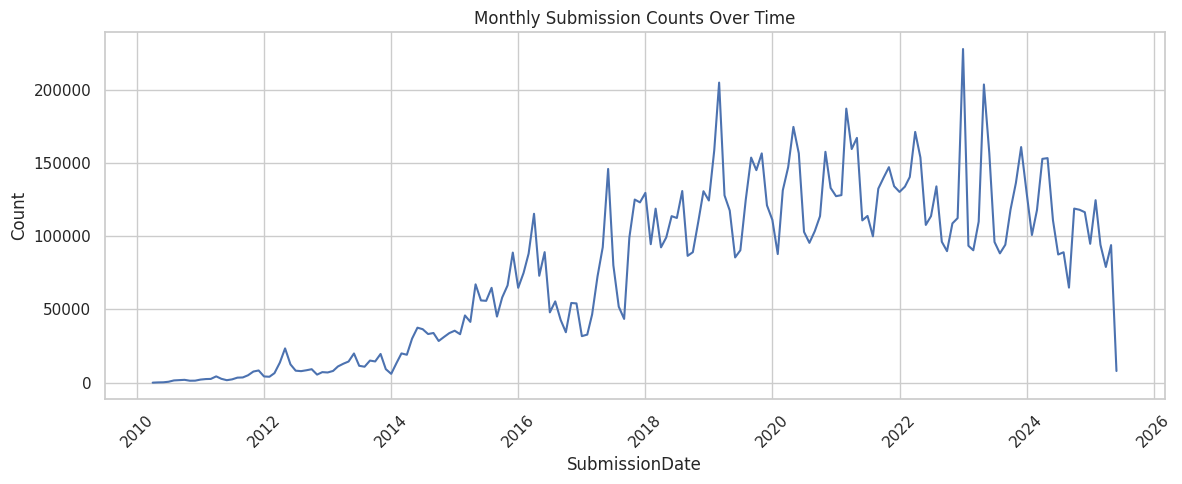

In [12]:
# 2. Submission counts over time (monthly)
submissions_clean_df['SubmissionDate'] = pd.to_datetime(submissions_clean_df['SubmissionDate'], errors='coerce')
monthly_submissions = submissions_clean_df.groupby(submissions_clean_df['SubmissionDate'].dt.to_period('M')).size().reset_index(name='Count')
monthly_submissions['SubmissionDate'] = monthly_submissions['SubmissionDate'].dt.to_timestamp()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_submissions, x='SubmissionDate', y='Count')
plt.title("Monthly Submission Counts Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

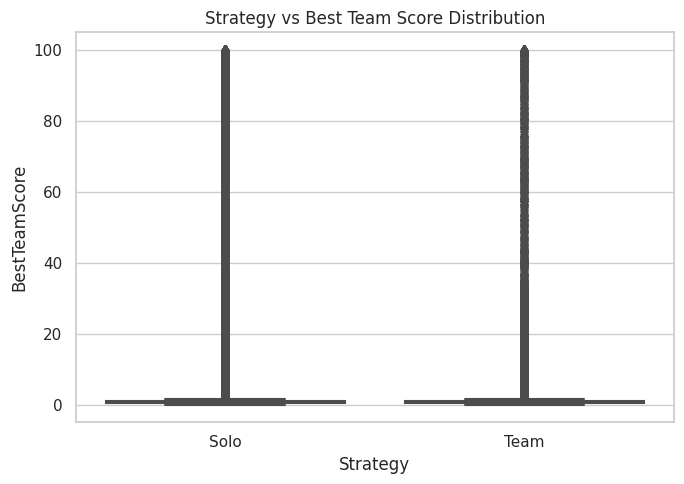

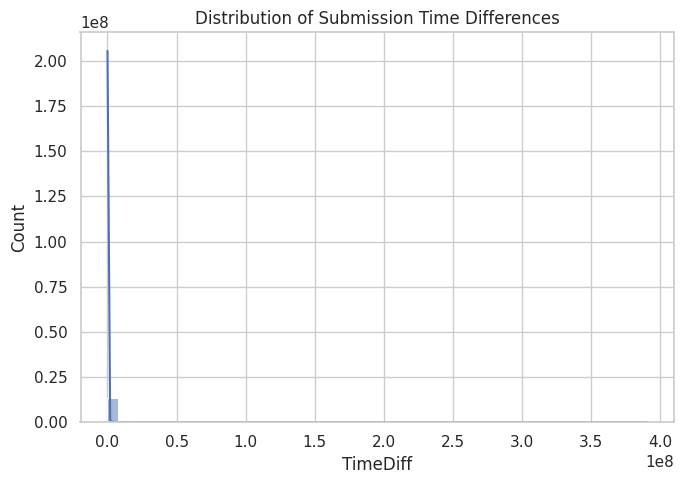

In [13]:
# 3. Compare Strategy vs BestTeamScore distribution
plt.figure(figsize=(7,5))
sns.boxplot(data=team_perf_df, x='Strategy', y='BestTeamScore')
plt.title("Strategy vs Best Team Score Distribution")
plt.tight_layout()
plt.show()

# 4. TimeDiff distribution (submission delay)
plt.figure(figsize=(7,5))
sns.histplot(submissions_clean_df['TimeDiff'].dropna(), bins=50, kde=True)
plt.title("Distribution of Submission Time Differences")
plt.tight_layout()
plt.show()

## Code Analytics

In [14]:
base_path_code = CODE_PATH

def get_source_code_by_path(file_name):
    result = {
        "found": False,
        "actual_file_path": "",
        "error": "",
        "source_code": [],
        "cell_types": [],
        "total_cells": 0,
        "code_cells": 0,
        "file_extension": ".ipynb",
        "id_verification": file_name
    }

    try:
        base_path = Path("/kaggle/input/meta-kaggle-code")
        file_path = next(base_path.rglob(file_name), None)

        if file_path is None:
            result["error"] = "File not found"
            return result

        result["actual_file_path"] = str(file_path)
        with open(file_path, 'r', encoding='utf-8') as f:
            nb = json.load(f)

        cells = nb.get("cells", [])
        result["total_cells"] = len(cells)

        for cell in cells:
            cell_type = cell.get("cell_type", "")
            result["cell_types"].append(cell_type)
            source = "".join(cell.get("source", []))
            result["source_code"].append(source)
            if cell_type == "code":
                result["code_cells"] += 1

        result["found"] = True

    except Exception as e:
        result["error"] = str(e)

    return result

def get_file_extension(file_path):
    """Get file extension."""
    return os.path.splitext(file_path)[1]

def analyze_notebook_content(notebook):
    """Analyze notebook content and return statistics."""
    source_code = []
    cell_types = []
    cell_lengths = []
    
    for cell in notebook.cells:
        if cell.cell_type in ['code', 'markdown', 'raw']:
            source_code.append(cell.source)
            cell_types.append(cell.cell_type)
            cell_lengths.append(len(cell.source))
    
    # Calculate statistics
    code_cells = len([c for c in notebook.cells if c.cell_type == 'code'])
    markdown_cells = len([c for c in notebook.cells if c.cell_type == 'markdown'])
    raw_cells = len([c for c in notebook.cells if c.cell_type == 'raw'])
    total_chars = sum(cell_lengths)
    
    return {
        'source_code': source_code,
        'cell_types': cell_types,
        'cell_lengths': cell_lengths,
        'total_cells': len(notebook.cells),
        'code_cells': code_cells,
        'markdown_cells': markdown_cells,
        'raw_cells': raw_cells,
        'total_characters': total_chars,
        'average_cell_length': total_chars / len(source_code) if source_code else 0,
        'notebook_metadata': notebook.metadata if hasattr(notebook, 'metadata') else {}
    }

def analyze_python_file(file_path):
    """
    Analyze a .py file and return statistics.
    
    Args:
        file_path (str): Path to the .py file
        
    Returns:
        dict: Code analysis result
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            code = f.read()
        
        lines = code.splitlines()
        total_lines = len(lines)
        empty_lines = sum(1 for line in lines if not line.strip())
        comment_lines = sum(1 for line in lines if line.strip().startswith("#"))
        code_lines = total_lines - empty_lines - comment_lines
        
        return {
            'file_path': file_path,
            'total_lines': total_lines,
            'code_lines': code_lines,
            'comment_lines': comment_lines,
            'empty_lines': empty_lines,
            'total_characters': len(code),
            'average_line_length': len(code) / total_lines if total_lines else 0,
        }
    except Exception as e:
        return {
            'file_path': file_path,
            'error': str(e),
        }

def create_error_result(id, expected_path, error_msg):
    """Create standardized error result."""
    return {
        'id': id,
        'expected_file_path': expected_path,
        'actual_file_path': None,
        'found': False,
        'found_at_expected_location': False,
        'file_extension': get_file_extension(expected_path) if expected_path else None,
        'id_verification': None,
        'error': error_msg
    }

# Utility function for quick info display
def print_notebook_info(result):
    if result['found']:
        print(f"✅ Notebook found: {result['actual_file_path']}")
        print(f"🔢 ID: {result['id_verification']}")
        print(f"📄 Extension: {result['file_extension']}")
        print(f"📦 Total Cells: {result['total_cells']}")
        print(f"🧠 Code Cells: {result['code_cells']}")
    else:
        print(f"❌ Error: {result['error']}")

def get_version_by_id(version_id):
    """Fetch Kernel Version row by ID"""
    row = kernel_versions_df[kernel_versions_df['Id'] == version_id]
    if row.empty:
        raise KeyError(f"Version ID {version_id} not found.")
    return row.iloc[0].to_dict()

def get_kernel_by_id(script_id):
    """Fetch Kernel row by ScriptId"""
    row = kernels_df[kernels_df['Id'] == script_id]
    if row.empty:
        raise KeyError(f"Script ID {script_id} not found.")
    return row.iloc[0].to_dict()

def extract_code_cells(notebook_id):
    result = get_source_code_by_path(notebook_id)  # ← FIXED LINE
    if result['found']:
        return [code for i, code in enumerate(result['source_code']) if result['cell_types'][i] == 'code']
    return []

def extract_imports_and_keywords(import_list, all_source_code):
    keywords = ['sklearn', 'xgboost', 'lightgbm', 'catboost', 'tensorflow', 'keras', 'pytorch', 'transformers', 'fastai']
    
    libs_counter = Counter(import_list)
    keyword_counter = Counter()

    full_code = "\n".join(all_source_code).lower()
    for kw in keywords:
        if kw in full_code:
            keyword_counter[kw] += 1

    return libs_counter, keyword_counter

import ast

def extract_imports(code_cells):
    """
    Extract imported libraries from code cells using AST.
    
    Args:
        code_cells (list): List of code cell strings

    Returns:
        list: Flattened list of imported libraries
    """
    imports = []

    for code in code_cells:
        try:
            tree = ast.parse(code)
            for node in ast.walk(tree):
                if isinstance(node, ast.Import):
                    for alias in node.names:
                        imports.append(alias.name.split('.')[0])
                elif isinstance(node, ast.ImportFrom):
                    if node.module:
                        imports.append(node.module.split('.')[0])
        except Exception:
            continue  # Skip cells with syntax errors

    return imports

def extract_imports_from_code_cells(code_cells):
    imports = []
    import_pattern = re.compile(r'^\s*(import|from)\s+([\w\.]+)')
    for code in code_cells:
        for line in code.split('\n'):
            match = import_pattern.match(line)
            if match:
                imports.append(match.group(2))
    return imports

def get_notebook_date_and_domain(version_id):
    version_info = get_version_by_id(version_id)
    # Extract date and problem domain tags if available
    date = version_info.get('Date')  # Adjust field name as per your df
    domain = version_info.get('CompetitionType', 'Unknown')  # Or other domain column
    return date, domain

def aggregate_trends(notebook_ids, version_ids):
    records = []

    for nb_id, ver_id in zip(notebook_ids, version_ids):
        code_cells = extract_code_cells(nb_id)
        imports_list = extract_imports_from_code_cells(code_cells)
        
        all_source_code = "\n".join(code_cells)  # combine for second argument
        
        libs, keywords = extract_imports_and_keywords(imports_list, all_source_code)
        
        try:
            date, domain = get_notebook_date_and_domain(ver_id)
        except Exception:
            date, domain = None, 'Unknown'
        
        record = {
            'notebook_id': nb_id,
            'version_id': ver_id,
            'date': pd.to_datetime(date, errors='coerce'),
            'domain': domain,
            'libraries': libs,
            'techniques': keywords
        }
        records.append(record)

    return pd.DataFrame(records)

In [15]:
# check files from code
count = 0
until = 20
for dirname, _, filenames in os.walk(CODE_PATH):
    for filename in filenames:
        print(dirname)
        print(filename)
        count += 1
        if count >= until:
            break  # Exit the inner loop (filenames)
    if count >= until:
        break  # Exit the outer loop (directories)

/kaggle/input/meta-kaggle-code/0111/437
111437525.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437241.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437855.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437029.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437556.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437861.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437760.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437323.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437657.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437589.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437496.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437048.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437351.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437968.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437212.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437734.ipynb
/kaggle/input/meta-kaggle-code/0111/437
111437529.ipynb
/kaggle/input/meta-kaggle-code/0111/437
11143765

In [16]:
# Example usage
file_name = "111515770.ipynb"
result = get_source_code_by_path(file_name)

print(len(result))

# Extract code-only cells
if result['found']:
    code_only = [code for i, code in enumerate(result['source_code']) 
                 if result['cell_types'][i] == 'code']

9


In [17]:
# 📌 Step 1: Aggregate All Libraries from All Notebooks
all_imports = []

count = 0
until = 200
for dirname, _, filenames in os.walk(CODE_PATH):
    for file_name in filenames:
        count += 1
        if count >= until:
            break  # Exit inner loop
        
        # file_path = os.path.join(dirname, file_name)
        result = get_source_code_by_path(file_name)
  
        if result['found'] and result['source_code']:
            code_only = [code for i, code in enumerate(result['source_code']) 
                         if result['cell_types'][i] == 'code']
            
            for block in code_only:
                if block.strip():  # skip empty cells
                    imports = re.findall(r'^\s*(?:import|from)\s+([\w\.]+)', block, re.MULTILINE)
                    all_imports.extend(imports)
    
    if count >= until:
        break  # Exit outer loop

# ✅ Safeguard: Check if data exists
if not all_imports:
    print("⚠️ No imports found in any notebook. Please check if files contain code.")
else:
    print(f"✅ Total imports extracted: {len(all_imports)}")


✅ Total imports extracted: 2311


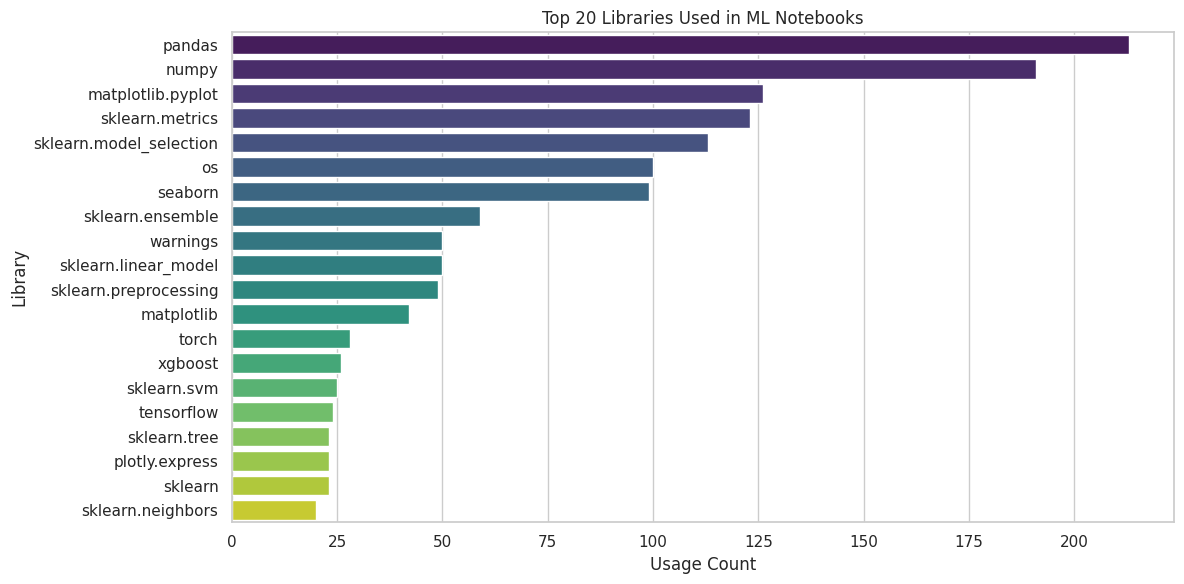

In [18]:
# 📌 Step 2: Count and Visualize Library Usage
if all_imports:
    lib_counter = Counter(all_imports)
    top_libs = lib_counter.most_common(20)
    df_libs = pd.DataFrame(top_libs, columns=['Library', 'Count'])

    plt.figure(figsize=(12,6))
    sns.barplot(data=df_libs, x='Count', y='Library', palette='viridis')
    plt.title("Top 20 Libraries Used in ML Notebooks")
    plt.xlabel("Usage Count")
    plt.ylabel("Library")
    plt.tight_layout()
    plt.show()
else:
    print("No imports found. Please check source code extraction or import parsing.")

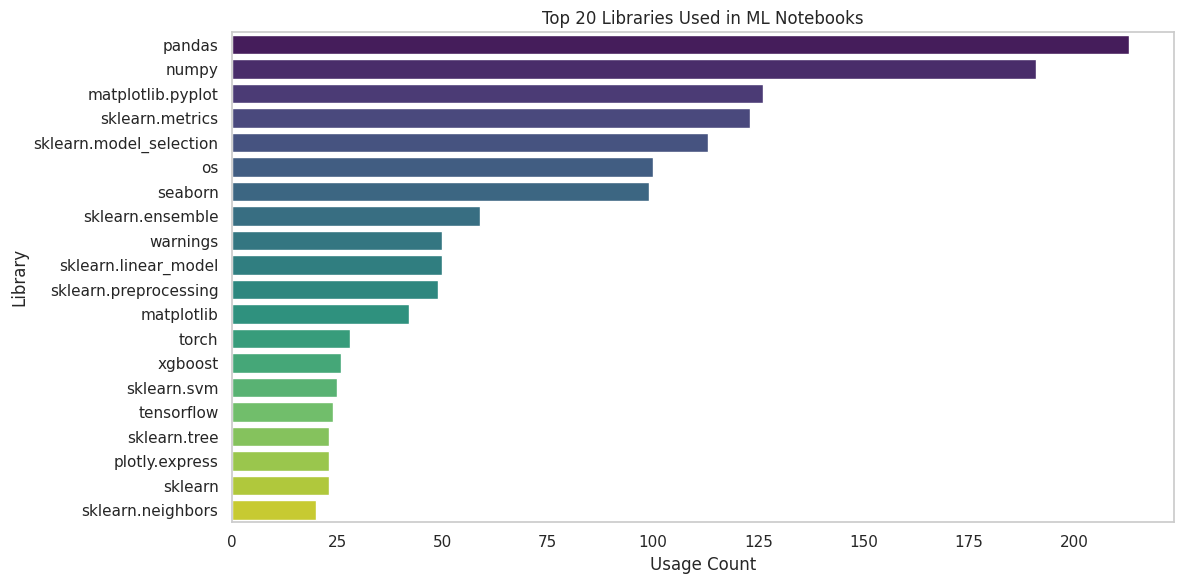

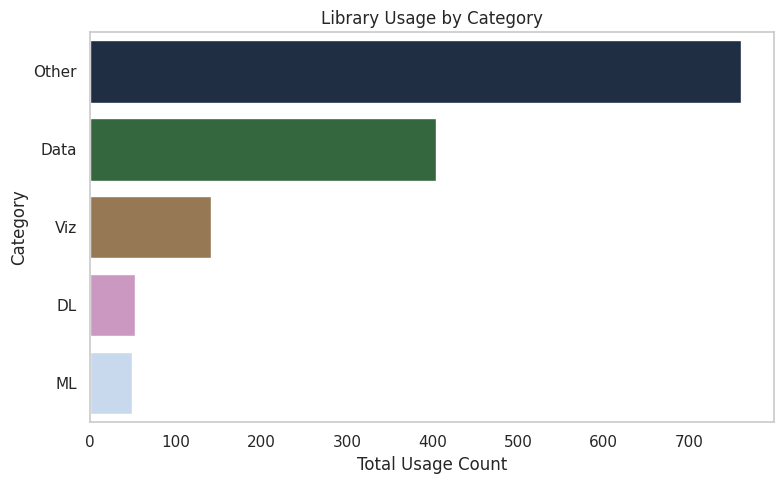

In [19]:
# ⚠️ Make sure `all_imports` contains strings like 'pandas', 'sklearn', etc.
if not all_imports:
    print("⚠️ No imports found. Exiting.")
else:
    # 📊 Count frequency
    lib_counter = Counter(all_imports)
    top_libs = lib_counter.most_common(20)

    # 📄 Create DataFrame
    df_libs = pd.DataFrame(top_libs, columns=['Library', 'Count'])

    # 🎨 Plot top 20 libraries
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_libs, x='Count', y='Library', palette='viridis')
    plt.title("Top 20 Libraries Used in ML Notebooks")
    plt.xlabel("Usage Count")
    plt.ylabel("Library")
    plt.tight_layout()
    plt.grid(axis='x')
    plt.show()

    # 🧪 Optional: Analyze categories of libraries
    lib_categories = {
        'pandas': 'Data',
        'numpy': 'Data',
        'sklearn': 'ML',
        'xgboost': 'ML',
        'lightgbm': 'ML',
        'tensorflow': 'DL',
        'keras': 'DL',
        'matplotlib': 'Viz',
        'seaborn': 'Viz',
        'plotly': 'Viz',
        'transformers': 'NLP',
        'torch': 'DL',
        'nltk': 'NLP',
        'spacy': 'NLP',
        'cv2': 'CV',
        'albumentations': 'CV',
        'catboost': 'ML',
        'statsmodels': 'Stat',
        'scipy': 'Data'
    }

    df_libs['Category'] = df_libs['Library'].apply(lambda lib: lib_categories.get(lib.lower(), 'Other'))

    # 📈 Category-wise distribution
    df_cat = df_libs.groupby('Category')['Count'].sum().reset_index().sort_values(by='Count', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_cat, x='Count', y='Category', palette='cubehelix')
    plt.title("Library Usage by Category")
    plt.xlabel("Total Usage Count")
    plt.ylabel("Category")
    plt.tight_layout()
    plt.grid(axis='x')
    plt.show()


Top keywords: []
Monthly data sample:
 Empty DataFrame
Columns: [date]
Index: []
Sum per keyword:
 Series([], dtype: float64)


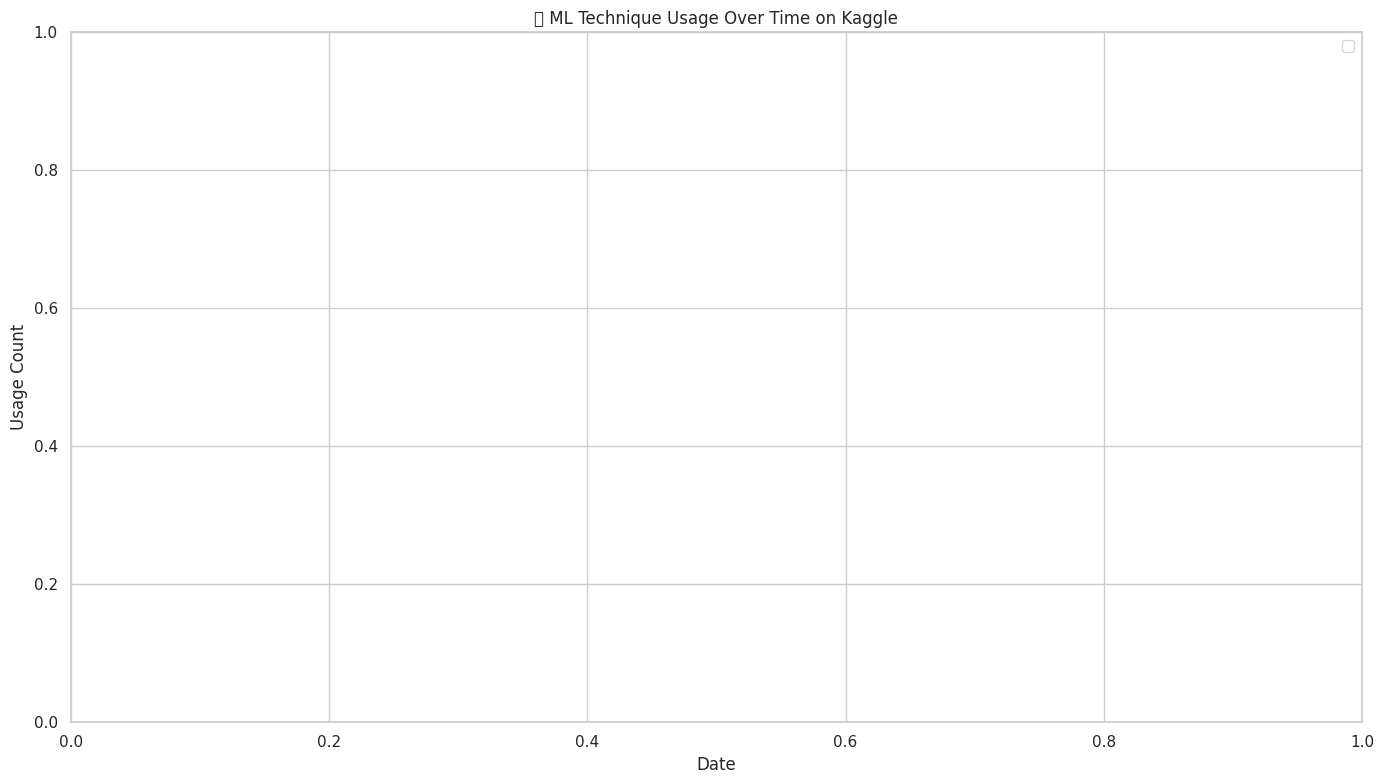

In [20]:
# Step 1: Aggregate trends
df_sample = kernel_versions_df.sample(500)  # Or .head(1000)
df_trends = aggregate_trends(df_sample['ScriptId'].tolist(), df_sample['Id'].tolist())
# df_trends = aggregate_trends(kernel_versions_df['ScriptId'].tolist(), kernel_versions_df['Id'].tolist())

# Step 2: Expand libraries and techniques columns
df_libs_expanded = df_trends['libraries'].apply(lambda x: pd.Series(x)).fillna(0).astype(int)
df_techs_expanded = df_trends['techniques'].apply(lambda x: pd.Series(x)).fillna(0).astype(int)

# Step 3: Combine with date and domain
df_combined = pd.concat([df_trends[['date', 'domain']], df_libs_expanded, df_techs_expanded], axis=1)

# Step 3.5: Ensure datetime and drop invalid dates
df_combined['date'] = pd.to_datetime(df_combined['date'], errors='coerce')
df_combined = df_combined.dropna(subset=['date'])

# Step 4: Group by time (monthly) and compute sum
df_monthly = df_combined.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()

# Step 5: Plot trends for top techniques
top_keywords = df_techs_expanded.sum().sort_values(ascending=False).head(10).index

print("Top keywords:", list(top_keywords))
print("Monthly data sample:\n", df_monthly[['date'] + list(top_keywords)].head())

# Check if all zeros
print("Sum per keyword:\n", df_monthly[top_keywords].sum())

plt.figure(figsize=(14, 8))
for kw in top_keywords:
    plt.plot(df_monthly['date'], df_monthly[kw], label=kw)

plt.title("📈 ML Technique Usage Over Time on Kaggle")
plt.xlabel("Date")
plt.ylabel("Usage Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()